# Generate Trajectory subsequence

| ID | 目的                                  | 模型设定（固定）                                  | 子集                 |
| -- | ----------------------------------- | ----------------------------------------- | ------------------ |
| E8 | context 对强周期/高频（routine）是否有害？       | Encoder-only + (Grid+UserID+Time) + Fuzzy | Routine subset     |
| E9 | context 对弱周期/非例行（non-routine）是否更有用？ | Encoder-only + (Grid+UserID+Time) + Fuzzy | Non-routine subset |


1. 生成强周期/高频轨迹子序列。
2. 生成弱周期/低频轨迹子序列。

## 获取子序列

In [2]:
import os
import pandas as pd

GeoLife_df = pd.read_csv('Data/Output/all_users_context_combined.csv')
MoreUser_df = pd.read_csv('Data/MoreUser/all.csv')

In [ ]:

def GetSubsequence(df, topk=3, savePath="./Data/Output/split_by_topk_"):
    # ====== 1) 读入数据 ======
    # 可选：清理无用列
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # ====== 3) 保持原始时间顺序：用原始行号做稳定排序锚点 ======
    df = df.copy()
    df["orig_idx"] = range(len(df))

    # ====== 4) 输出目录 ======
    out_root = savePath + f"{topk}"
    high_dir = os.path.join(out_root, "high_freq")
    low_dir  = os.path.join(out_root, "low_freq")
    os.makedirs(high_dir, exist_ok=True)
    os.makedirs(low_dir, exist_ok=True)

    # 可选：也保存合并版
    high_all = []
    low_all = []

    # ====== 5) 按 userID 分别提取并保存 ======
    for user_id, g in df.groupby("userID", sort=False):
        # 统计该用户各 grid 的访问频次（行数）
        grid_counts = g["grid"].value_counts(dropna=False)

        # 该用户 top-k 高频 grid（按频次从高到低）
        topk_grids = grid_counts.head(topk).index.tolist()

        # 高频/低频拆分
        g_high = g[g["grid"].isin(topk_grids)].sort_values("orig_idx")
        g_low  = g[~g["grid"].isin(topk_grids)].sort_values("orig_idx")

        # 保存每个用户的文件
        g_high.drop(columns=["orig_idx"]).to_csv(
            os.path.join(high_dir, f"user_{user_id}_high_top{topk}.csv"),
            index=False
        )
        g_low.drop(columns=["orig_idx"]).to_csv(
            os.path.join(low_dir, f"user_{user_id}_low_top{topk}.csv"),
            index=False
        )

        # 汇总（合并版）
        high_all.append(g_high)
        low_all.append(g_low)

    # ====== 6) 保存合并版（所有用户放一起） ======
    high_all_df = pd.concat(high_all, ignore_index=True).drop(columns=["orig_idx"])
    low_all_df  = pd.concat(low_all,  ignore_index=True).drop(columns=["orig_idx"])

    high_all_df.to_csv(os.path.join(out_root, f"Routine_top{topk}.csv"), index=False)
    low_all_df.to_csv(os.path.join(out_root, f"Nonroutine_top{topk}.csv"), index=False)

    print("Done.")
    print("Per-user files saved to:")
    print("  ", high_dir)
    print("  ", low_dir)
    print("Merged files saved to:")
    print("  ", os.path.join(out_root, f"Routine_top{topk}.csv"))
    print("  ", os.path.join(out_root, f"Nonroutine_top{topk}.csv"))


In [5]:
GetSubsequence(GeoLife_df, topk=3)

Done.
Per-user files saved to:
   ./Data/Output/split_by_topk_3\high_freq
   ./Data/Output/split_by_topk_3\low_freq
Merged files saved to:
   ./Data/Output/split_by_topk_3\Routine_top3.csv
   ./Data/Output/split_by_topk_3\Noroutine_top3.csv


In [ ]:
GetSubsequence(MoreUser_df, topk=3, savePath="./Data/MoreUser/split_by_topk_")
# consume 54.0 s.

Done.
Per-user files saved to:
   ./Data/MoreUser/split_by_topk_3\high_freq
   ./Data/MoreUser/split_by_topk_3\low_freq
Merged files saved to:
   ./Data/MoreUser/split_by_topk_3\Routine_top3.csv
   ./Data/MoreUser/split_by_topk_3\Noroutine_top3.csv


## 统计用户的 visit_ratio

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_and_plot_topk_visit_ratio(
    df,
    user_col="userID",
    grid_col="grid",
    topk=3,
    bins=20
):
    """
    统计不同用户的 top-k visit_ratio，并绘制分布图

    Parameters
    ----------
    df : pd.DataFrame
        轨迹数据（每一行是一条访问记录）
    user_col : str
        用户ID列名
    grid_col : str
        地点/grid列名
    topk : int
        取访问频率最高的前 k 个地点
    bins : int
        直方图的分箱数量

    Returns
    -------
    result_df : pd.DataFrame
        包含 [userID, visit_ratio]
    """

    results = []

    for user_id, g in df.groupby(user_col):
        # 每个地点的访问次数
        grid_counts = g[grid_col].value_counts()

        total_visits = grid_counts.sum()
        topk_visits = grid_counts.head(topk).sum()

        visit_ratio = (
            topk_visits / total_visits
            if total_visits > 0 else 0.0
        )

        results.append({
            user_col: user_id,
            "visit_ratio": visit_ratio
        })

    result_df = pd.DataFrame(results)

    # ===== 绘图 =====
    # 直方图的含义：x轴表示 top-k 访问比例的区间，y轴表示落在该区间的用户数量 。
    plt.figure()
    plt.hist(result_df["visit_ratio"], bins=bins)
    plt.xlabel(f"Top-{topk} Visit Ratio")
    plt.ylabel("Number of Users")
    plt.title(f"Distribution of Top-{topk} Visit Ratio Across Users")
    plt.show()

    return result_df


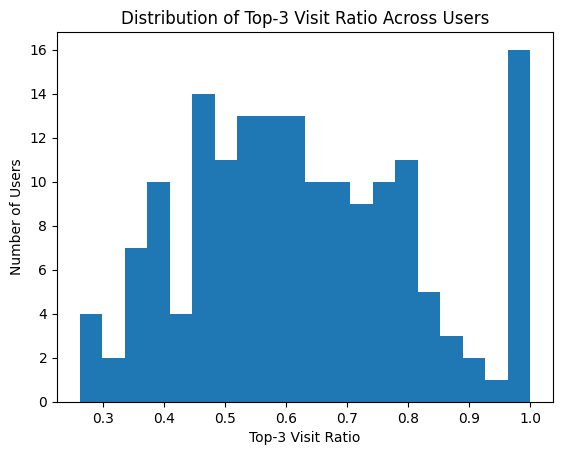

,userID,visit_ratio
0,0,0.795591
1,1,0.620438
2,2,0.736070
3,3,0.740530
4,4,0.791080
...,...,...
163,174,0.543860
164,175,0.444444
165,176,0.500000
166,179,0.554688


In [13]:
compute_and_plot_topk_visit_ratio(GeoLife_df)

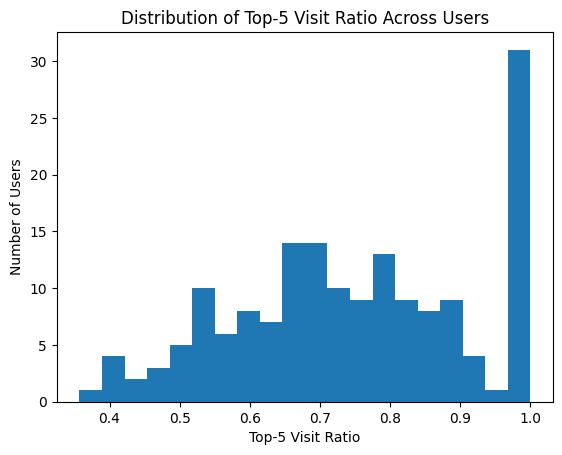

,userID,visit_ratio
0,0,0.815631
1,1,0.751825
2,2,0.782991
3,3,0.786932
4,4,0.831768
...,...,...
163,174,0.657895
164,175,0.666667
165,176,0.650000
166,179,0.695312


In [12]:
compute_and_plot_topk_visit_ratio(GeoLife_df, topk=5)

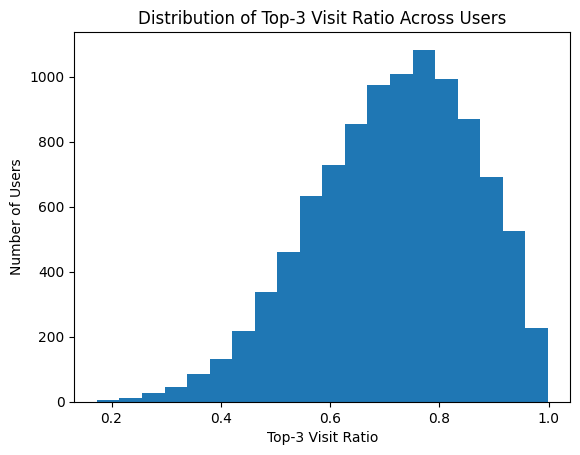

,userID,visit_ratio
0,0,0.553980
1,1,0.631579
2,2,0.829396
3,3,0.550186
4,4,0.789866
...,...,...
9902,9939,0.721831
9903,9940,0.793742
9904,9941,0.789333
9905,9942,0.572816


In [9]:
compute_and_plot_topk_visit_ratio(MoreUser_df)

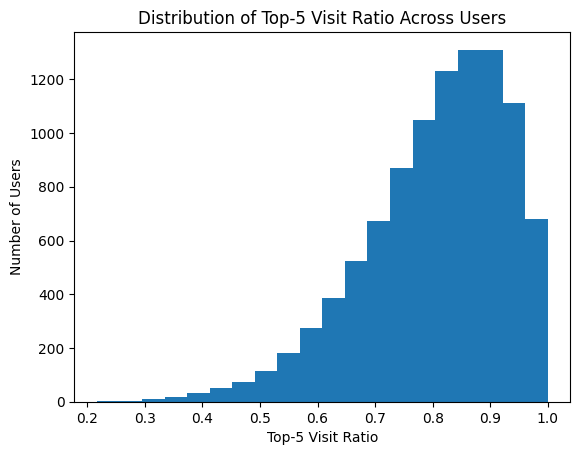

,userID,visit_ratio
0,0,0.628135
1,1,0.700229
2,2,0.889764
3,3,0.639405
4,4,0.852459
...,...,...
9902,9939,0.866197
9903,9940,0.886335
9904,9941,0.850667
9905,9942,0.693481


In [10]:
compute_and_plot_topk_visit_ratio(MoreUser_df, topk=5)

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

def compute_routine_statistics(
    data_path,
    user_col="userID",
    grid_col="grid",
    top_k=3
):
    """
    Compute routine / non-routine statistics based on Top-K visit ratio.

    Parameters
    ----------
    data_path : str or Path
        Path to stay-level trajectory file (CSV / Parquet).
    user_col : str
        Column name of user ID.
    grid_col : str
        Column name of discretized location (grid ID).
    top_k : int
        Number of top frequent locations used to define routine (default=3).

    Returns
    -------
    stats : dict
        {
            'micro_ratio': float,
            'macro_ratio_mean': float,
            'macro_ratio_std': float,
            'num_users': int,
            'num_stays': int
        }
    """

    data_path = Path(data_path)

    # -------- Load data --------
    if data_path.suffix == ".csv":
        df = pd.read_csv(data_path)
    elif data_path.suffix in [".parquet", ".pq"]:
        df = pd.read_parquet(data_path)
    else:
        raise ValueError(f"Unsupported file format: {data_path.suffix}")

    # Basic sanity check
    assert user_col in df.columns
    assert grid_col in df.columns

    num_stays = len(df)
    num_users = df[user_col].nunique()

    # -------- Identify routine grids per user --------
    routine_mask = np.zeros(len(df), dtype=bool)

    for user_id, user_df in df.groupby(user_col):
        # Count grid visit frequency
        grid_counts = user_df[grid_col].value_counts()

        # Top-K frequent grids
        top_grids = set(grid_counts.nlargest(top_k).index)

        # Mark routine stays
        idx = user_df.index
        routine_mask[idx] = user_df[grid_col].isin(top_grids).values

    df["is_routine"] = routine_mask

    # -------- Micro-average --------
    micro_ratio = df["is_routine"].mean()

    # -------- Macro-average --------
    user_ratios = (
        df.groupby(user_col)["is_routine"]
        .mean()
        .values
    )

    macro_ratio_mean = float(np.mean(user_ratios))
    macro_ratio_std = float(np.std(user_ratios))

    stats = {
        "micro_ratio": micro_ratio,
        "macro_ratio_mean": macro_ratio_mean,
        "macro_ratio_std": macro_ratio_std,
        "num_users": num_users,
        "num_stays": num_stays,
    }

    return stats


if __name__ == "__main__":
    # ===== Example usage =====
    # Replace paths with your actual files
    geolife_path = "./Data/Output/all_users_context_combined.csv"
    moreuser_path = "./Data/MoreUser/all.csv"

    print("=== GeoLife ===")
    geolife_stats = compute_routine_statistics(geolife_path)
    for k, v in geolife_stats.items():
        print(f"{k}: {v}")

    print("\n=== MoreUser ===")
    moreuser_stats = compute_routine_statistics(moreuser_path)
    for k, v in moreuser_stats.items():
        print(f"{k}: {v}")


=== GeoLife ===


AssertionError: 